In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from tensorflow.keras.layers import concatenate, BatchNormalization, Input, Add
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt
import cv2
import string
import glob

In [3]:
# Step 2: Define Paths
base_path = '/content/drive/My Drive/Flicker8k'
dataset_path = os.path.join(base_path, 'Flicker8k_Dataset')
token_path = os.path.join(base_path, 'Flickr8k.token.txt')
train_images_path = os.path.join(dataset_path, 'Flickr_8k.trainImages.txt')
images_path = os.path.join(dataset_path, 'Images')

In [4]:
# Step 3: Load Descriptions
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        if len(line) < 2:  # remove short descriptions
            continue

        # Use rstrip to remove potential trailing whitespace or newlines
        line = line.rstrip()

        # Use ',' as the delimiter instead of '\t'
        token = line.split(",")

        # Check if the line has at least two elements after splitting
        if len(token) >= 2:
            img_id = token[0].split('.')[0]  # name of the image
            img_des = token[1]  # description of the image
            if img_id not in mapping:
                mapping[img_id] = list()
            mapping[img_id].append(img_des)
        else:
            # Print lines that don't have the expected format for debugging
            print(f"Line with unexpected format: {line}")
    return mapping

with open(token_path, 'r', encoding='utf-8') as file:
    text = file.read()

descriptions = load_description(text)

# Check if the key exists before accessing it
if '1000268201_693b08cb0e' in descriptions:
    print("Descriptions for image '1000268201_693b08cb0e':", descriptions['1000268201_693b08cb0e'])
else:
    print(f"Key '1000268201_693b08cb0e' not found in descriptions. Available keys are: {list(descriptions.keys())[:10]}...") # Print first 10 keys for debugging

Descriptions for image '1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [5]:
# Step 4: Clean Descriptions
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
print("Cleaned descriptions for image '1000268201_693b08cb0e':", descriptions['1000268201_693b08cb0e'])

Cleaned descriptions for image '1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [6]:
import os

# Path to the Flicker8k_Dataset folder
dataset_path = '/content/drive/My Drive/Flicker8k/Flicker8k_Dataset'

# List all files and folders in the dataset folder
contents = os.listdir(dataset_path)
print("Contents of Flicker8k_Dataset folder:", contents)

Contents of Flicker8k_Dataset folder: ['385186343_464f5fc186 (1).jpg', '385835044_4aa11f6990.jpg', '384465575_31294122c0.jpg', '384465370_9918873f9a.jpg', '386656845_4e77c3e3da.jpg', '384577800_fc325af410.jpg', '386160015_d4b31df68e.jpg', '386470686_1ae9242878.jpg', '387078972_514a38dc33.jpg', '385186343_464f5fc186.jpg', '390992102_67fa31b22f.jpg', '387974450_bcd205daac.jpg', '390986651_c801db91a0.jpg', '390671130_09fdccd52f.jpg', '389643437_9a9830a3ba.jpg', '390360326_26f5936189.jpg', '390987167_2d5905b459.jpg', '388386075_9ac3a89ada.jpg', '387830531_e89c192b92.jpg', '391020801_aaaae1e42b.jpg', '391579205_c8373b5411.jpg', '392467282_00bb22e201.jpg', '392976422_c8d0514bc3.jpg', '391324644_d23fdf06cb.jpg', '391723162_3bdeb7ea33.jpg', '391106734_d374bc3080.jpg', '390992388_d74daee638.jpg', '393987665_91d28f0ed0.jpg', '394136487_4fc531b33a.jpg', '394563330_68b566368c.jpg', '393810324_1c33760a95.jpg', '393958545_48c17c66d1.jpg', '394161692_2576920777.jpg', '393284934_d38e1cd6fe.jpg', '3944

In [7]:
import os
import random

# Path to the Flicker8k_Dataset folder
dataset_path = '/content/drive/My Drive/Flicker8k/Flicker8k_Dataset'

# List all image files in the folder
all_images = [img for img in os.listdir(dataset_path) if img.endswith('.jpg')]
print("Total images:", len(all_images))

Total images: 8196


In [8]:
# Shuffle the list of images
random.shuffle(all_images)

# Split the dataset
train_size = int(0.8 * len(all_images))
test_size = int(0.1 * len(all_images))
train_images = all_images[:train_size]
test_images = all_images[train_size:train_size + test_size]
dev_images = all_images[train_size + test_size:]

print("Training images:", len(train_images))
print("Testing images:", len(test_images))
print("Validation images:", len(dev_images))

Training images: 6556
Testing images: 819
Validation images: 821


In [9]:
# Save the splits to text files
with open(os.path.join(dataset_path, 'Flickr_8k.trainImages.txt'), 'w') as file:
    file.write("\n".join(train_images))

with open(os.path.join(dataset_path, 'Flickr_8k.testImages.txt'), 'w') as file:
    file.write("\n".join(test_images))

with open(os.path.join(dataset_path, 'Flickr_8k.devImages.txt'), 'w') as file:
    file.write("\n".join(dev_images))

print("Dataset split and saved successfully!")

Dataset split and saved successfully!


In [10]:
# Verify the splits
print("Training images file exists:", os.path.exists(os.path.join(dataset_path, 'Flickr_8k.trainImages.txt')))
print("Testing images file exists:", os.path.exists(os.path.join(dataset_path, 'Flickr_8k.testImages.txt')))
print("Validation images file exists:", os.path.exists(os.path.join(dataset_path, 'Flickr_8k.devImages.txt')))

Training images file exists: True
Testing images file exists: True
Validation images file exists: True


In [11]:
# Paths to the dataset files
base_path = '/content/drive/My Drive/Flicker8k'
dataset_path = os.path.join(base_path, 'Flicker8k_Dataset')
token_path = os.path.join(base_path, 'Flickr8k.token.txt')
train_images_path = os.path.join(dataset_path, 'Flickr_8k.trainImages.txt')  # Path to training images list
test_images_path = os.path.join(dataset_path, 'Flickr_8k.testImages.txt')    # Path to test images list
dev_images_path = os.path.join(dataset_path, 'Flickr_8k.devImages.txt')      # Path to validation images list
images_path = dataset_path  # Images are in the Flicker8k_Dataset folder

# Load training images
with open(train_images_path, 'r', encoding='utf-8') as file:
    train_images = file.read().split("\n")

# Filter training images
train_img = [os.path.join(images_path, img) for img in train_images if img]
print("Number of training images:", len(train_img))
print("First training image:", train_img[0])

Number of training images: 6556
First training image: /content/drive/My Drive/Flicker8k/Flicker8k_Dataset/3323498985_fd9d2803fd.jpg


In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np



# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg') # Use InceptionV3
model = Model(base_model.input, base_model.output)


In [27]:
# Function to preprocess and encode an image
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [28]:
import time
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import gc


# Function to preprocess and encode an image
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Function to encode images
def encode(image_path):
    image = preprocess_img(image_path)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    del image  # Free up memory
    gc.collect()  # Run garbage collector
    return vec




In [29]:
# Step 7: Encode Images in Batches
batch_size = 100  # Process 100 images at a time
encoding_train = {}
start_time = time.time()

for i in range(0, len(train_img), batch_size):
    batch = train_img[i:i + batch_size]
    for img_path in batch:
        img_id = os.path.basename(img_path).split('.')[0]
        encoding_train[img_id] = encode(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

KeyboardInterrupt: 

In [30]:
# Load saved progress
with open('/content/drive/My Drive/Flicker8k/encoding_train.pkl', 'rb') as file:
    encoding_train = pickle.load(file)

# Define batch_size here before the loop
batch_size = 100  # Process 100 images at a time

# Continue encoding from the last batch
start_index = len(encoding_train)
for i in range(start_index, len(train_img), batch_size):
    batch = train_img[i:i + batch_size]
    for img_path in batch:
        img_id = os.path.basename(img_path).split('.')[0]
        encoding_train[img_id] = encode(img_path)

    # Print progress
    print(f"Encoded {min(i + batch_size, len(train_img))}/{len(train_img)} images")

    # Save progress after each batch
    with open('/content/drive/My Drive/Flicker8k/encoding_train.pkl', 'wb') as file:
        pickle.dump(encoding_train, file)
    print("Progress saved!")

In [31]:
# Step 8: Tokenize Vocabulary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# List of all training captions
all_train_captions = []
for key, val in descriptions.items():
    for caption in val:
        all_train_captions.append(caption)


In [32]:
# Create a set of all unique words in the captions
vocabulary = set()
for cap in all_train_captions:
    for word in cap.split(' '):
        vocabulary.add(word)

In [33]:
# Filter out rare words (words that occur less than a threshold)
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Vocabulary size:", len(vocab))

Vocabulary size: 1900


In [34]:
# Create word-to-index and index-to-word mappings
ixtoword = {}
wordtoix = {}
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [35]:
# Find the maximum length of a caption
max_length = max(len(des.split()) for des in all_train_captions)
print("Max caption length:", max_length)

Max caption length: 29


In [37]:
# Step 9: Prepare Data for Training
X1, X2, y = [], [], []  # Keep X1, X2, y as lists initially

for key, des_list in descriptions.items():
    if key + '.jpg' in train_images and key in encoding_train:  # Check if key is in encoding_train
        pic = encoding_train[key]

        # Check if the shape is (2048,) or reshape if necessary
        if pic.shape != (2048,):
            if pic.shape == (1, 2048):
                pic = pic.reshape(2048,)
            else:
                print(f"Warning: Image {key} has unexpected shape: {pic.shape}. Skipping.")
                continue

        # Iterate through captions for the image
        for cap in des_list:
            seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=len(vocab) + 1)[0]

                # Append data to lists
                X1.append(pic)
                X2.append(in_seq)
                y.append(out_seq)

# Convert X1 to a NumPy array outside the loops
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

# Reshape X1 to (num_samples, 2048) if necessary
if X1.shape[1] != 2048:  # Assuming the feature dimension is the second dimension
    X1 = X1.reshape(-1, 2048)  # -1 infers the number of samples

# Now X1, X2, and y should have consistent shapes





In [ ]:
print([len(x) for x in X1])
print([len(x) for x in X2])
print([len(x) for x in y])

[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 2048, 2048, 204

In [38]:
# Step 10: Define the Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add

# List of all training captions  -- Added this block to define all_train_captions
all_train_captions = []
for key, val in descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
#---

# Create a set of all unique words in the captions # This block is added
vocabulary = set()
for cap in all_train_captions:
    for word in cap.split(' '):
        vocabulary.add(word)
# Filter out rare words (words that occur less than a threshold)
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Vocabulary size:", len(vocab))
#---

# Define the model
ip1 = Input(shape=(2048,)) # Input for image features (updated to 1024)
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation='relu')(fe1)
max_length = max(len(des.split()) for des in all_train_captions)
print("Max caption length:", max_length)

ip2 = Input(shape=(max_length,))  # Input for captions
se1 = Embedding(len(vocab) + 1, 200, mask_zero=True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])  # Combine image and text features
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vocab) + 1, activation='softmax')(decoder2)

model = Model(inputs=[ip1, ip2], outputs=outputs)
model.summary()

Vocabulary size: 1900
Max caption length: 29


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 29)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 29, 200)        │        380,200 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 29, 200)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 29)             │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        467,968 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1901)           │        488,557 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,927,061 (7.35 MB)

 Trainable params: 1,927,061 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Step 11: Compile and Train the Model
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit([X1, X2], y, epochs=50, batch_size=256)



Epoch 1/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 330s 647ms/step - loss: 5.3868
Epoch 2/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 386s 656ms/step - loss: 3.7108
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 383s 659ms/step - loss: 3.2615
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 376s 646ms/step - loss: 2.9744
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 384s 650ms/step - loss: 2.7649
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 379s 645ms/step - loss: 2.5789
Epoch 7/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 381s 643ms/step - loss: 2.4192
Epoch 8/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 325s 644ms/step - loss: 2.2977
Epoch 9/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 381s 641ms/step - loss: 2.1632
Epoch 10/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 384s 646ms/step - loss: 2.0605
Epoch 11/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 382s 646ms/step - loss: 1.9702
Epoch 12/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 382s 647ms/step - loss: 1.8734
Epoch 13/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 378s 639ms/step - loss: 1.8028
Epoch 14/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 379s 634ms/step - loss: 1.7372
E

In [40]:
# Step 12: Save the Model
model.save('/content/drive/My Drive/Flicker8k/image_captioning_model.h5')
print("Model saved!")

Model saved!


In [41]:
# Step 13: Generate Captions
def greedy_search(pic):
    # Ensure wordtoix and ixtoword are defined before using them
    # Create word-to-index and index-to-word mappings
    # (This part was likely in a different cell and not executed before calling greedy_search)
    ixtoword = {}
    wordtoix = {}
    ix = 1
    for word in vocab:  # Assuming 'vocab' is defined and contains your vocabulary
        wordtoix[word] = ix
        ixtoword[ix] = word
        ix += 1

    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen=max_length)
        # Reshape pic to have a batch dimension
        pic = pic.reshape(1, -1)  # Reshape to (1, 1024) for MobileNet or (1, 2048) for InceptionV3
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [42]:
# Ensure the following cell is executed before the cell with the error:

# Paths to the dataset files
base_path = '/content/drive/My Drive/Flicker8k'
dataset_path = os.path.join(base_path, 'Flicker8k_Dataset')
token_path = os.path.join(base_path, 'Flickr8k.token.txt')
train_images_path = os.path.join(dataset_path, 'Flickr_8k.trainImages.txt')  # Path to training images list
test_images_path = os.path.join(dataset_path, 'Flickr_8k.testImages.txt')    # Path to test images list
dev_images_path = os.path.join(dataset_path, 'Flickr_8k.devImages.txt')      # Path to validation images list
images_path = dataset_path  # Images are in the Flicker8k_Dataset folder

# Load training images
with open(train_images_path, 'r', encoding='utf-8') as file:
    train_images = file.read().split("\n")

# Filter training images
train_img = [os.path.join(images_path, img) for img in train_images if img]
print("Number of training images:", len(train_img))
print("First training image:", train_img[0])

Number of training images: 6556
First training image: /content/drive/My Drive/Flicker8k/Flicker8k_Dataset/3323498985_fd9d2803fd.jpg


In [51]:
# Step 13: Generate Captions
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen=max_length)
        # Reshape pic to have a batch dimension of 1
        pic = pic.reshape(1, -1)  # Reshape to (1, 2048) for InceptionV3, -1 infers the correct dimension
        yhat = model.predict([pic, seq]) # The model expects pic to be (1, 2048)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

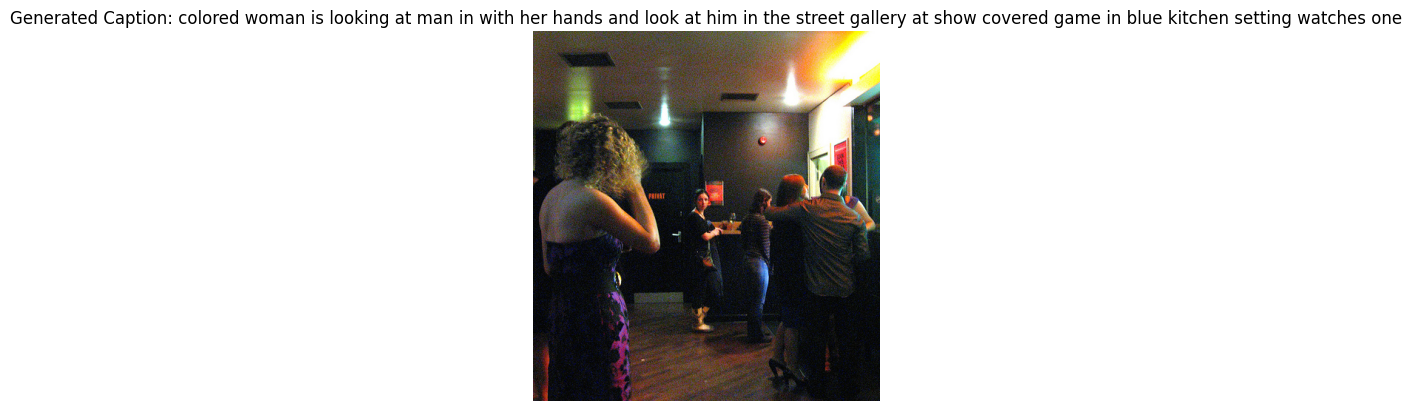

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Your existing code to generate the caption
available_keys = list(encoding_train.keys())
sample_image_id = available_keys[0]  # Choose the first key for example
sample_image = os.path.join(images_path, sample_image_id + '.jpg')  # Reconstruct the full path

# Generate the caption (your existing logic)
pic = encoding_train[sample_image_id]
caption = greedy_search(pic)
print("Generated caption:", caption)

# New code to display the image
img = mpimg.imread(sample_image)  # Load the image
plt.imshow(img)  # Display the image
plt.axis('off')  # Hide the axes
plt.title("Generated Caption: " + caption)  # Add the caption as the title
plt.show()  # Show the image